In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import activations
from tensorflow.python.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Read Data
data = pd.read_csv("YESBANK.NS.csv")
#Display top 10 rows
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-21,18.950001,19.000000,18.000000,18.000000,18.000000,168955038
1,2020-12-22,17.400000,17.600000,17.100000,17.299999,17.299999,284913909
2,2020-12-23,17.500000,17.850000,17.049999,17.600000,17.600000,216066991
3,2020-12-24,17.900000,18.000000,17.299999,17.549999,17.549999,124638448
4,2020-12-28,17.799999,18.200001,17.549999,17.799999,17.799999,149082382


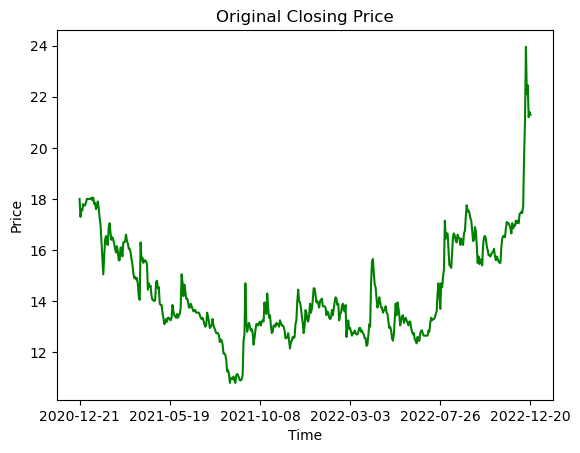

In [4]:
plt.plot(data['Close'], color=(0, 0.5, 0))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Original Closing Price')
plt.xticks(range(0, len(data['Close']), 496//5), data['Date'][0:496:496//5])
plt.savefig('Original Closing Price')
plt.show()

In [5]:
#we deletd the columns date and close because we are predicting the closing price
ds = data.drop(['Date', 'Close'], axis=1).fillna(0).to_numpy().reshape((-1, 5, 1))
#fill = it wil remove all the null values
#numpy = it will convert the pandas data frame  to numpy ND array
# reshape = used to increase the dimension by one so that it can be used conv 1D layer
ds = np.hstack([ds, np.zeros((ds.shape[0], 3,1))]).astype(np.float32)
#hstack = used to append 3 column to zeros so that data shape is compliant to auto encoder
# as type = used to convert all int values to float
ds = ds - np.mean(ds, axis=0, keepdims=True)
# normal mean
ds[:, 4, :] /= 214860840
# normalize the normal column of volume

In [6]:
ds.shape

(496, 8, 1)

In [7]:
# Must be divisible by 2
bottle_neck_size = 4

In [8]:
#encoder model
enc = models.Sequential([
    layers.InputLayer((8, 1)),
    layers.Conv1D(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(filters=8, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    layers.Flatten(),
    layers.Dense(bottle_neck_size),
])
enc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 8, 8)              32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 8)              200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 16)             400       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 16)             784       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 32)             1568      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [9]:
#decoder part
dec = models.Sequential([
    layers.InputLayer((bottle_neck_size // 2,)),
    layers.Dense(64),
    layers.Reshape((2, 32)),
    layers.Conv1DTranspose(filters=16, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1DTranspose(filters=16, kernel_size=3, activation='relu'),
    layers.Conv1DTranspose(filters=8, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1DTranspose(filters=8, kernel_size=3, activation='relu'),
    layers.Conv1DTranspose(filters=1, kernel_size=3),
])
dec.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
reshape (Reshape)            (None, 2, 32)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 2, 16)             1552      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 4, 16)             784       
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 4, 8)              392       
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 6, 8)              200       
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 8, 1)             

In [10]:

def decode(_dec, z, apply_sigmoid=False):
    logits = _dec(z)
    if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
    return logits

def encode(_enc, x):
    mean, logvar = tf.split(_enc(x), num_or_size_splits=2, axis=1)
    return mean, logvar

@tf.function
def sample(_dec, eps=None):
    if eps is None:
        eps = tf.random.normal(shape=(100, bottle_neck_size))
    return decode(_dec, eps, apply_sigmoid=True)

def reparameterize(mean, logvar):
    # eps = tf.random.normal(shape=mean.shape)
    eps = tf.random.normal(shape=(1, 2))
    return eps * tf.exp(logvar * .5) + mean

In [12]:
optimizer = tf.keras.optimizers.RMSprop(1e-5)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(_enc, _dec, x):
    mean, logvar = encode(_enc, x)
    z = reparameterize(mean, logvar)
    x_logit = _dec(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(_enc, _dec, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(_enc, _dec, x)
    trainable_variables = _enc.trainable_variables + _dec.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [13]:

epochs = 3

stat_reports = 3

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

batch = 32

enc.trainable = True

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

for report in range(1, stat_reports + 1):
    start_time = time.time()

    for _ in range(epochs):
        # # Stochastic Gradient Descent
        # for train_x in ds:
        #     train_step(enc, dec, train_x[None], optimizer)

        # # Batch Gradient Descent
        # train_step(enc, dec, ds, optimizer)

        # # Mini Batch Gradient Descent
        for i in range(len(ds) - batch + 1):
            train_step(enc, dec, ds[i:i+batch], optimizer)

    end_time = time.time()

    # elbo = 0
    loss = tf.keras.metrics.Mean()
    for test_x in ds:
        loss(compute_loss(enc, dec, test_x[None]))
    elbo = tf.abs(loss.result())
    # display.clear_output(wait=False)
    print('Report: {}, Train set ELBO: {}, time elapsed: {}'
          .format(report, elbo, (end_time - start_time) / epochs))

print("Number of epoch processed:", epochs * stat_reports)

2024-08-30 23:30:58.607530: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Report: 1, Train set ELBO: 5.430003643035889, time elapsed: 1.6735686461130779
Report: 2, Train set ELBO: 5.285403728485107, time elapsed: 0.9823343753814697
Report: 3, Train set ELBO: 5.0989670753479, time elapsed: 0.8370117346445719
Number of epoch processed: 9


In [14]:
#predictor part
pre = models.Sequential([
    layers.InputLayer((bottle_neck_size,)),
    # layers.Reshape((bottle_neck_size, 1)),
    # layers.Conv1DTranspose(filters=8, kernel_size=3, activation='relu'),
    # layers.Conv1DTranspose(filters=16, kernel_size=3, activation='relu'),
    # layers.MaxPool1D(pool_size=2),
    # layers.Conv1DTranspose(filters=32, kernel_size=3, activation='relu'),
    # layers.Conv1DTranspose(filters=64, kernel_size=3, activation='relu'),
    # layers.MaxPool1D(pool_size=2),
    # layers.Conv1D(filters=1, kernel_size=3),
    # layers.MaxPool1D(pool_size=2),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
    layers.Reshape((1, 1))
])
pre.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1)             

In [15]:
yd = data['Close'].fillna(0).to_numpy().reshape((-1, 1, 1))
yd.shape

(496, 1, 1)

In [16]:
#this is a model which combines the encoder and predictor so that we can train the predictor
predictor_trainer = models.Sequential([
    layers.InputLayer((8, 1)),
    enc,
    pre
])
predictor_trainer.compile(
    # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.00001),
    optimizer=optimizers.adam_v2.Adam(learning_rate=0.0001),
    loss=losses.MAPE,
    metrics=['mse', 'mape', 'mae']
)

In [17]:
# Reunited our samples with their labels and made batches of size 32
tfds = tf.data.Dataset.from_tensor_slices((ds, yd)).batch(256)

In [21]:
enc.trainable = False# so that our encoder part will not change at the time of prdicting
h = predictor_trainer.fit(
    # x=ds, y=yd,
    x=tfds,
    epochs=500
)

Epoch 1/500
2/2 [==============================] - 0s 7ms/step - loss: 0.2694 - mse: 0.0041 - mape: 0.2694 - mae: 0.0392
Epoch 2/500
2/2 [==============================] - 0s 10ms/step - loss: 0.2416 - mse: 0.0039 - mape: 0.2416 - mae: 0.0351
Epoch 3/500
2/2 [==============================] - 0s 100ms/step - loss: 0.2412 - mse: 0.0038 - mape: 0.2412 - mae: 0.0350
Epoch 4/500
2/2 [==============================] - 0s 7ms/step - loss: 0.2813 - mse: 0.0042 - mape: 0.2813 - mae: 0.0403
Epoch 5/500
2/2 [==============================] - 0s 5ms/step - loss: 0.2666 - mse: 0.0040 - mape: 0.2666 - mae: 0.0383
Epoch 6/500
2/2 [==============================] - 0s 8ms/step - loss: 0.2841 - mse: 0.0043 - mape: 0.2841 - mae: 0.0411
Epoch 7/500
2/2 [==============================] - 0s 8ms/step - loss: 0.2570 - mse: 0.0039 - mape: 0.2570 - mae: 0.0370
Epoch 8/500
2/2 [==============================] - 0s 7ms/step - loss: 0.2441 - mse: 0.0038 - mape: 0.2441 - mae: 0.0358
Epoch 9/500
2/2 [============

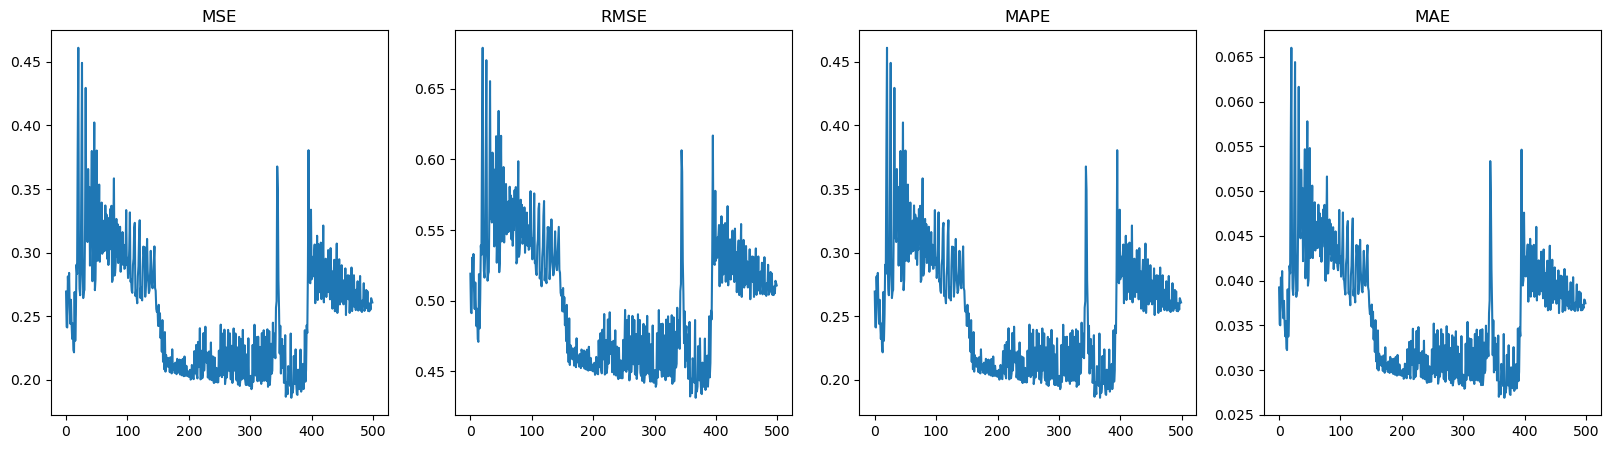

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(h.history['loss'])
axs[0].set_title('MSE')
axs[1].plot(np.sqrt(h.history['loss']))
axs[1].set_title('RMSE')
axs[2].plot(h.history['mape'])
axs[2].set_title('MAPE')
axs[3].plot(h.history['mae'])
axs[3].set_title('MAE')
plt.show()

In [23]:
enc.save('VaeEncoder')
dec.save('VaeDecoder')
pre.save('VaePredictor')

INFO:tensorflow:Assets written to: VaeEncoder/assets


INFO:tensorflow:Assets written to: VaeEncoder/assets


INFO:tensorflow:Assets written to: VaeDecoder/assets


INFO:tensorflow:Assets written to: VaeDecoder/assets


INFO:tensorflow:Assets written to: VaePredictor/assets


INFO:tensorflow:Assets written to: VaePredictor/assets


In [24]:
enc = models.load_model('VaeEncoder')
dec = models.load_model('VaeDecoder')
pre = models.load_model('VaePredictor')

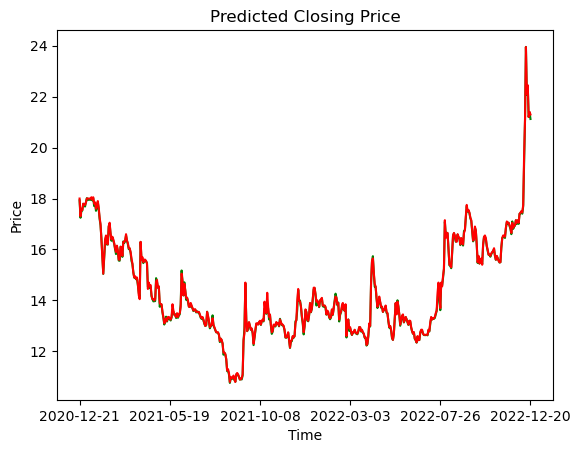

In [26]:
pred = predictor_trainer.predict(ds)[:, 0, 0]
plt.plot(pred, color=(0, 0.5, 0))
plt.plot(data['Close'], color=(1, 0, 0))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted Closing Price')
plt.xticks(range(0, len(pred), 496//5), data['Date'][0:496:496//5])
plt.show()
np.save('VAE_ELM', pred)